## Get reflectance bands, latitudes and longitudes from a downloaded dataset

In [1]:
import sys
sys.path.append('../../.')

In [2]:
from utils import apply_mask, get_color_mask, project_and_resample, to_raster
import xarray as xr
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [3]:
satdir = "../../../S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3/"
ds=xr.open_mfdataset([satdir + "Oa08_reflectance.nc", satdir + "geo_coordinates.nc"])

## Get WQSF flag from a downloaded dataset
Appropriate flags to choose for each of the Sentinel-3 OLCI OL2WFR bands can be found here: https://user.eumetsat.int/s3/eup-strapi-media/Recommendations_for_Sentinel_3_OLCI_Ocean_Colour_product_validations_in_comparison_with_in_situ_measurements_Matchup_Protocols_V8_B_e6c62ce677.pdf

In [4]:
Oa08_mask = get_color_mask(satdir+"wqsf.nc")

In [5]:
maskOa08 = apply_mask(Oa08_mask, ds["Oa08_reflectance"].data.compute())

In [6]:
lons = ds["longitude"] 
lats = ds["latitude"]

## Resample

See utils.py for further details on the project_and_resample function

In [7]:
result_no_flags, areadef_no_flags = project_and_resample("baltic_sea_WGS84", ds["Oa08_reflectance"].data.compute(), lons, lats)
result_flags, areadef_flags=project_and_resample("baltic_sea_WGS84", maskOa08, lons, lats)

Rounding shape to (4815, 7408) and resolution from (0.002700000000000813, 0.00269999999999726) meters to (0.0026997840172786176, 0.0026998961578400833) meters
Rounding shape to (4815, 7408) and resolution from (0.002700000000000813, 0.00269999999999726) meters to (0.0026997840172786176, 0.0026998961578400833) meters


In [8]:
crs_no_flags = areadef_no_flags.to_cartopy_crs()
crs_flags = areadef_flags.to_cartopy_crs()

### Plot

In [9]:
from datetime import datetime
from satpy import Scene, find_files_and_readers

In [10]:
files=find_files_and_readers(sensor="olci",
                               start_time=datetime(2024, 6, 25, 0, 0),
                               end_time=datetime(2024, 6, 30, 0, 0),
                               base_dir="../../../.",
                               reader="olci_l2")

In [11]:
scn = Scene(filenames=files)

In [12]:
scn.load(["Oa08","Oa06", "Oa03"])

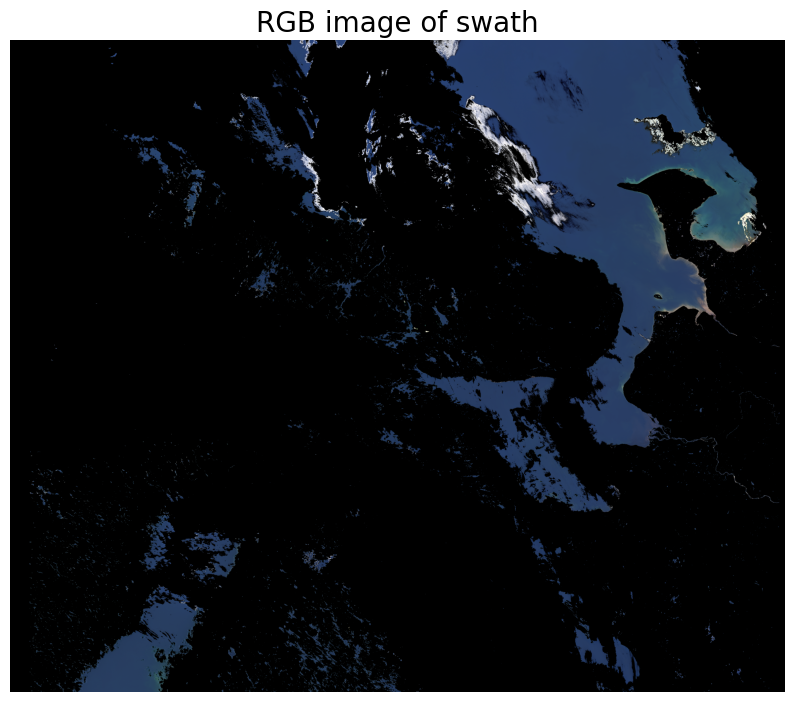

In [13]:
def normalize(array):
    array_min, array_max = np.nanpercentile(array, (1, 99))  # Clip values between 1st and 99th percentile
    array = np.clip(array, array_min, array_max)  # Clip the extreme values
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)
red = scn["Oa08"]
green = scn["Oa06"]
blue = scn["Oa03"]
red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

# Combine the channels into an RGB image
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Plot the RGB composite image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('RGB image of swath',fontdict={"fontsize":20})
plt.axis('off')
plt.show()

In [14]:
def plot_result(result, crs, title):
    fig, ax = plt.subplots(subplot_kw=dict(projection=crs), figsize=(20,20))
    coastlines = ax.coastlines()
    ax.set_global()
    img = plt.imshow(result, transform=crs, extent=crs.bounds, origin='upper')
    cbar = plt.colorbar()
    plt.title(title, fontdict={"fontsize":20})

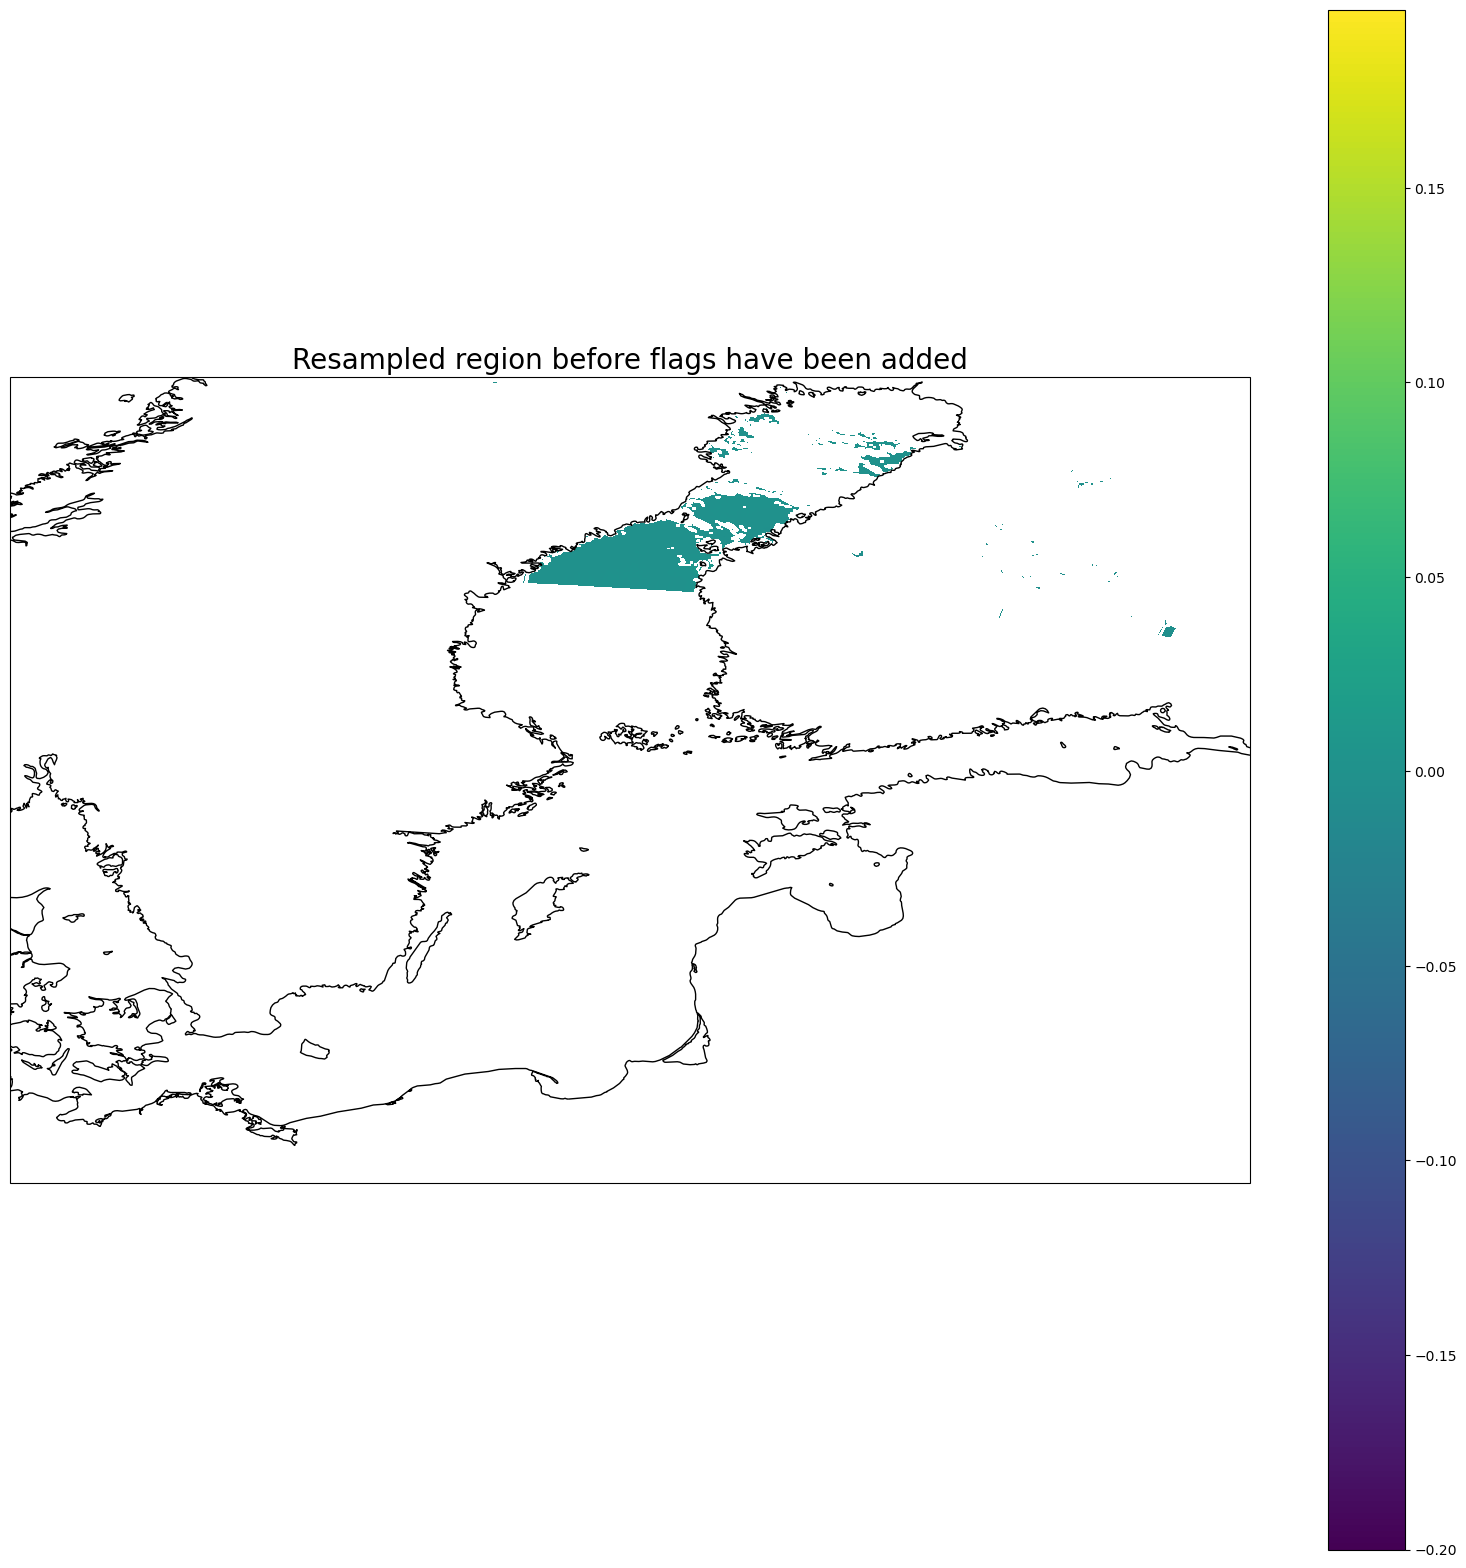

In [15]:
plot_result(result_no_flags, crs_no_flags, "Resampled region before flags have been added")

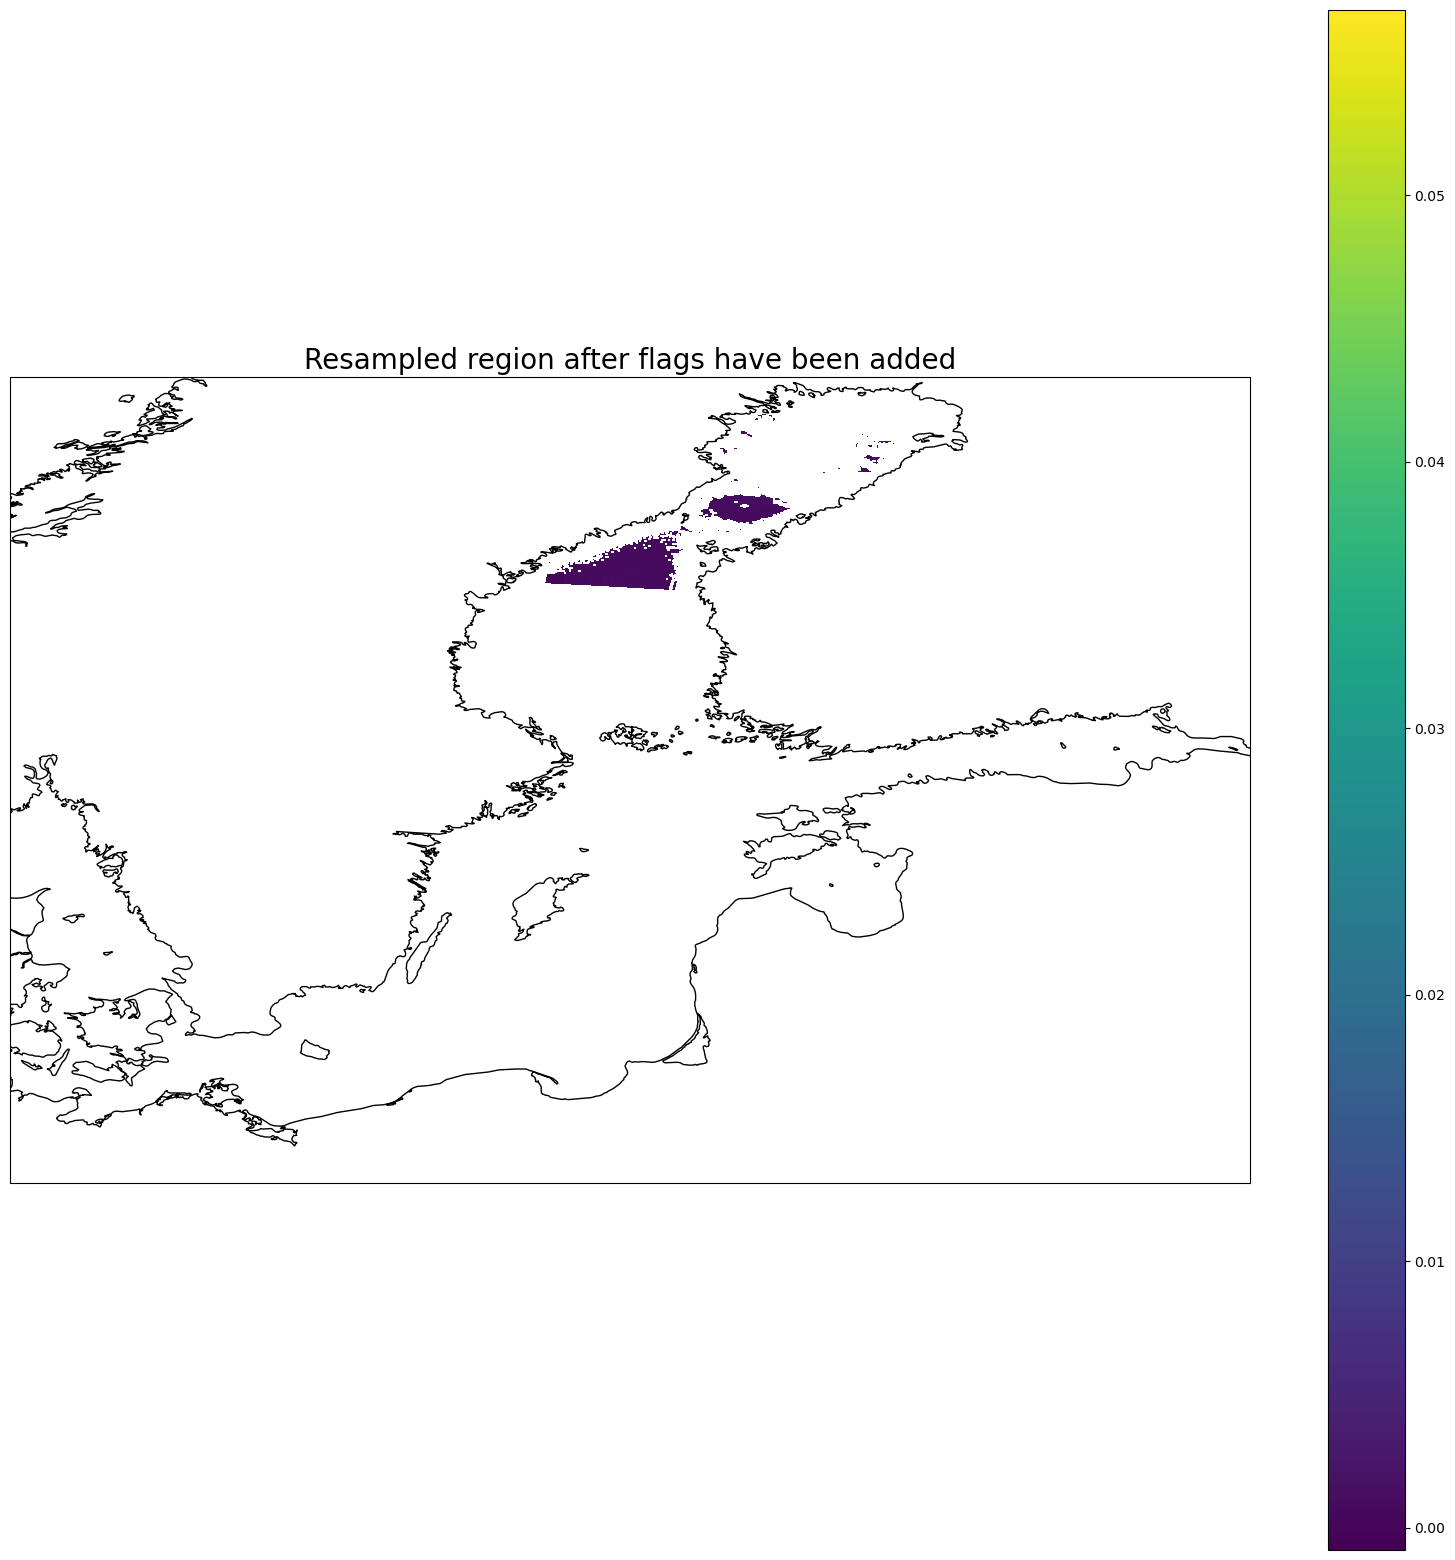

In [16]:
plot_result(result_flags, crs_flags, "Resampled region after flags have been added")

## Write result to raster

See utils.py for more details on the apply_mask and to_raster functions.

In [17]:
mask_result = apply_mask(result_flags.mask, result_flags.data)

In [18]:
to_raster([mask_result], "myGeoTIFF.tif",mask_result.shape, areadef_flags.resolution, 1)

### Plot and verify

In [19]:
import rasterio
from rasterio import plot

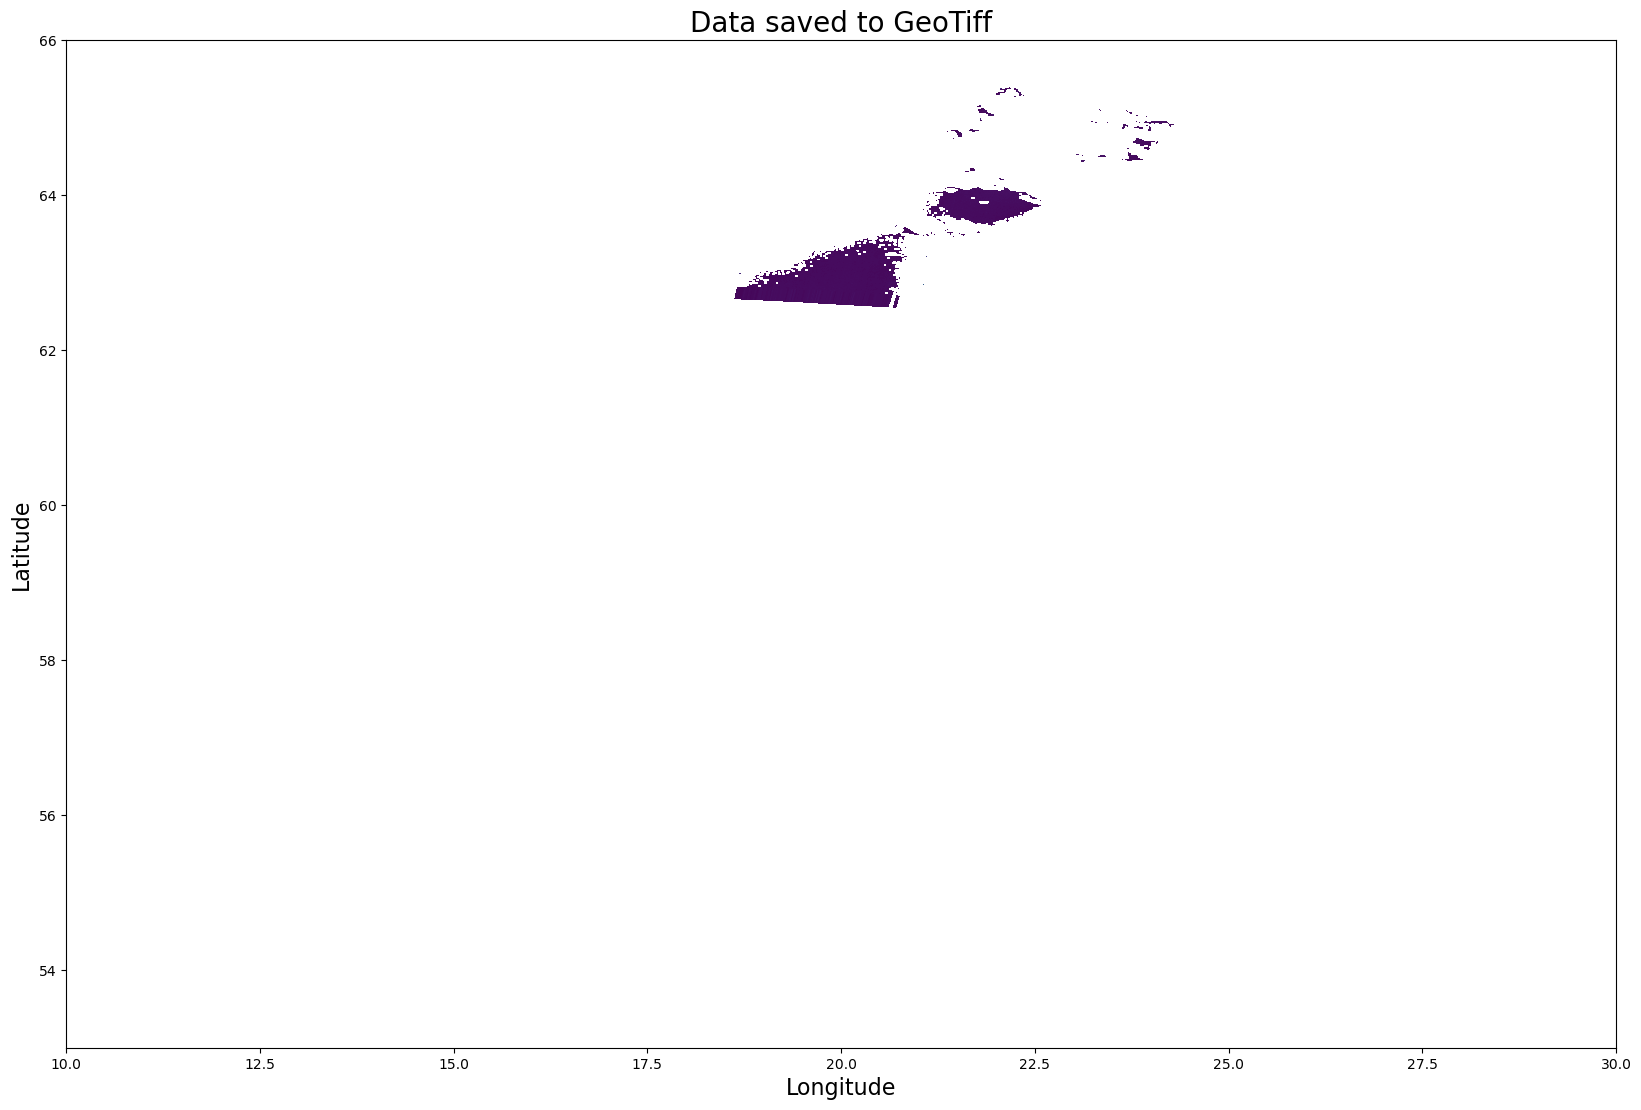

<Axes: title={'center': 'Data saved to GeoTiff'}, xlabel='Longitude', ylabel='Latitude'>

In [24]:
im=rasterio.open("myGeoTIFF.tif")
fig, ax = plt.subplots(figsize=(20,20))
plt.title("Data saved to GeoTiff", fontdict={"fontsize":20})
plt.xlabel("Longitude", fontdict={"fontsize":16})
plt.ylabel("Latitude", fontdict={"fontsize":16})
plot.show(im)

## Conclusion

This looks correct as the region we are covering seems intact and the pixels are only covering the northern parts of the baltic sea